# Import Data & Necessary Packages


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                                                            r2_score)
from uszipcode import SearchEngine
import seaborn as sns
from pysal.lib import weights
from pysal.model import spreg
import gmplot
import warnings
import contextily as cx
from shapely.geometry import Point
import seaborn as sns
import geopandas as gpd
warnings.filterwarnings("ignore")

In [58]:
data = pd.read_csv('../data/Drinking_Water_Quality_Distribution_Monitoring_Data_20241116.csv',
                                                                  low_memory = False)                       

# Data Cleaning 


In [59]:
# rename columns
data.rename(columns = {'Sample Date': 'sample_date', 'Sample Site': 'sample_site', 
              'Sample class': 'sample_class', 'Residual Free Chlorine (mg/L)': 'chlorine',
              'Turbidity (NTU)': 'turbidity', 'Coliform (Quanti-Tray) (MPN /100mL)': 'coliform',
                                      'E.coli(Quanti-Tray) (MPN/100mL)': 'ecoli'}, inplace = True)

In [60]:
# ensure sample time column is clean
data.dropna(subset = ['Sample Time'], inplace = True)

# standardize format of sample time
data['Sample Time'] = data['Sample Time'].apply(lambda x: x[11:16] if len(x) > 5 else x)

# change to datetime format
data['sample_date'] = pd.to_datetime(data['sample_date'] + ' ' + data['Sample Time'])

# change turbidity to float
data.loc[data['turbidity'] == '<0.10', 'turbidity'] = '0.10'
data['turbidity'] = data['turbidity'].apply(lambda x: float(x))

# Check the first few rows after creating 'sample_date'
print(data[['sample_date']].head())

          sample_date
0 2016-08-09 10:31:00
1 2016-08-09 11:27:00
2 2016-08-09 10:14:00
3 2016-08-09 12:12:00
4 2016-08-09 10:17:00


In [61]:
# drop unecessary columns and rows
data.drop(columns = ['Sample Number', 'Fluoride (mg/L)', 'Sample Time'], inplace = True)

In [62]:
# impute non-float values
catval = {'<0.10': float(0.09), '<1': float(0.99), '>200.5': float(200.6)}
data = data.replace(catval)

# change data types to float
data['chlorine'] = data['chlorine'].astype(float)
data['coliform'] = data['coliform'].astype(float)
data['ecoli'] = data['ecoli'].astype(float)

In [63]:
# check to make sure all values are possible
data = data[data['chlorine'] > 0]
data = data[data['coliform'] > 0]
data = data[data['ecoli'] > 0]

In [64]:
# only 4 missing values total - drop
data = data.dropna()

data.shape

(148701, 7)

In [65]:
# read in data for sampling sites
sites = pd.read_csv('../data/sampling_sites_extended.csv')

# use search engine to find demographic data
search = SearchEngine() 

zipdata = [] 

for zipcode in sites['ZIP Code']: 
  info = search.by_zipcode(zipcode)

  if bool(info) == True: 
    zipdata.append({
      'ZIP Code': zipcode,
      'housing_units': info.housing_units / 1000,
      'occupied_housing_units': info.occupied_housing_units / 1000, 
      'median_home_value': info.median_home_value / 1000,
      'median_household_income': info.median_household_income / 1000
    })

# add demographic data to sampling sites
zipdata = pd.DataFrame(zipdata) 
sites = pd.merge(sites, zipdata, how = 'inner', on = 'ZIP Code')
sites = sites.drop_duplicates()

# merge with location based information
sites.rename(columns = {'Sample Site': 'sample_site'}, inplace = True)

data = pd.merge(data, sites, on = 'sample_site')

In [66]:
# set 'sample_date' as the index and sort by 'sample_date'
data = data.set_index('sample_date')
data = data.sort_values(by='sample_date')

# prepare for modelling
data = data.drop(columns = ['OBJECTID', 'sample_site', 'sample_class', 
                            'Sample Station (SS) - Location Description',
                            'X - Coordinate', 'Y - Coordinate',
                            'City or Placename'])

# separate location data columns from the rest of the data
location_columns = ['ZIP Code', 'latitude', 'longitude', 'housing_units', 'occupied_housing_units', 
                    'median_home_value', 'median_household_income']

# identify the other columns (excluding location data)
columns_to_scale = [col for col in data.columns if col not in location_columns]

# scale only the non-location columns
data[columns_to_scale] = (data[columns_to_scale] - data[columns_to_scale].mean()) / data[columns_to_scale].std()

# save cleaned and merged data to new file
data.to_csv('../data/data_merged.csv', index=False)

## Borough information


In [ ]:
from uszipcode import SearchEngine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# lowercase column names
data.columns = data.columns.str.lower()

# initialize the search engine
search = SearchEngine()

# list of nyc boroughs
nyc_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Define a dictionary mapping neighborhoods/cities to boroughs
neighborhood_to_borough = {
    # Manhattan neighborhoods
    'New York': 'Manhattan',
    'Harlem': 'Manhattan',
    'Upper West Side': 'Manhattan',
    'Upper East Side': 'Manhattan',
    'Chelsea': 'Manhattan',
    'SoHo': 'Manhattan',
    'Greenwich Village': 'Manhattan',
    'Tribeca': 'Manhattan',
    'Financial District': 'Manhattan',
    'Lower East Side': 'Manhattan',
    'East Village': 'Manhattan',
    'Midtown': 'Manhattan',

    # Queens neighborhoods
    'Forest Hills': 'Queens',
    'Jackson Heights': 'Queens',
    'Astoria': 'Queens',
    'Ridgewood': 'Queens',
    'Sunnyside': 'Queens',
    'Flushing': 'Queens',
    'Long Island City': 'Queens',
    'Woodside': 'Queens',
    'Bayside': 'Queens',
    'Rego Park': 'Queens',
    'Elmhurst': 'Queens',
    'Kew Gardens': 'Queens',
    'Oakland Gardens': 'Queens',
    'Fresh Meadows': 'Queens',
    'Whitestone': 'Queens',
    'Corona': 'Queens',
    'Maspeth': 'Queens',
    'Jamaica': 'Queens',
    'Queens Village': 'Queens',
    'South Ozone Park': 'Queens',
    'Far Rockaway': 'Queens',
}

def get_borough(zipcode):
    # Fetch the information about the zipcode
    info = search.by_zipcode(zipcode)
    if info and info.major_city:
        major_city = info.major_city
        print(f"Zipcode {zipcode}: major city = {major_city}")  # Debugging output
        
        # First, check if the city or neighborhood is explicitly mapped to a borough
        if major_city in neighborhood_to_borough:
            return neighborhood_to_borough[major_city]
        
        # If not, check if it's one of the 5 NYC boroughs
        if major_city in nyc_boroughs:
            return major_city
        
    return None

# Apply the function to the 'zip code' column to create a new 'borough' column
data['borough'] = data['zip code'].apply(lambda x: get_borough(str(x)))

# Handle missing boroughs using KNN

# Only use rows where borough is not null for training the model
impute_X = data[data['borough'].notnull()][['latitude', 'longitude']]
impute_Y = data[data['borough'].notnull()]['borough']

# Encode borough labels for classification
encoder = LabelEncoder()
impute_Y = encoder.fit_transform(impute_Y)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier()
knn.fit(impute_X, impute_Y)

# Predict missing boroughs based on latitude and longitude
X_missing = data[data['borough'].isnull()][['latitude', 'longitude']]
predicted_labels = knn.predict(X_missing)
predicted_boroughs = encoder.inverse_transform(predicted_labels)

# Fill missing boroughs in the data
data.loc[data['borough'].isnull(), 'borough'] = predicted_boroughs

# Check for remaining missing borough values
print(f'Missing boroughs after imputation: {data["borough"].isnull().sum()}')

import pandas as pd

# Now manually update the boroughs based on the `neighborhood_to_borough` dictionary
# Iterate over the `neighborhood_to_borough` mapping and update the 'borough' column
for neighborhood, borough in neighborhood_to_borough.items():
    data.loc[data['borough'] == neighborhood, 'borough'] = borough

# After the manual update, check for missing boroughs
print(f'Missing boroughs after manual update: {data["borough"].isnull().sum()}')

# Save the updated DataFrame
data.to_csv('data/merged_data_with_borough.csv', index=False)



Zipcode 11375: major city = Forest Hills
Zipcode 11201: major city = Brooklyn
Zipcode 11372: major city = Jackson Heights
Zipcode 11105: major city = Astoria
Zipcode 11217: major city = Brooklyn
Zipcode 11236: major city = Brooklyn
Zipcode 10453: major city = Bronx
Zipcode 10280: major city = New York
Zipcode 11229: major city = Brooklyn
Zipcode 10468: major city = Bronx
Zipcode 10009: major city = New York
Zipcode 11226: major city = Brooklyn
Zipcode 10469: major city = Bronx
Zipcode 11385: major city = Ridgewood
Zipcode 11220: major city = Brooklyn
Zipcode 10021: major city = New York
Zipcode 10466: major city = Bronx
Zipcode 11206: major city = Brooklyn
Zipcode 10024: major city = New York
Zipcode 11211: major city = Brooklyn
Zipcode 10468: major city = Bronx
Zipcode 10307: major city = Staten Island
Zipcode 10027: major city = New York
Zipcode 11233: major city = Brooklyn
Zipcode 10468: major city = Bronx
Zipcode 10451: major city = Bronx
Zipcode 10306: major city = Staten Island
Z

OSError: Cannot save file into a non-existent directory: 'data'

# Visualization


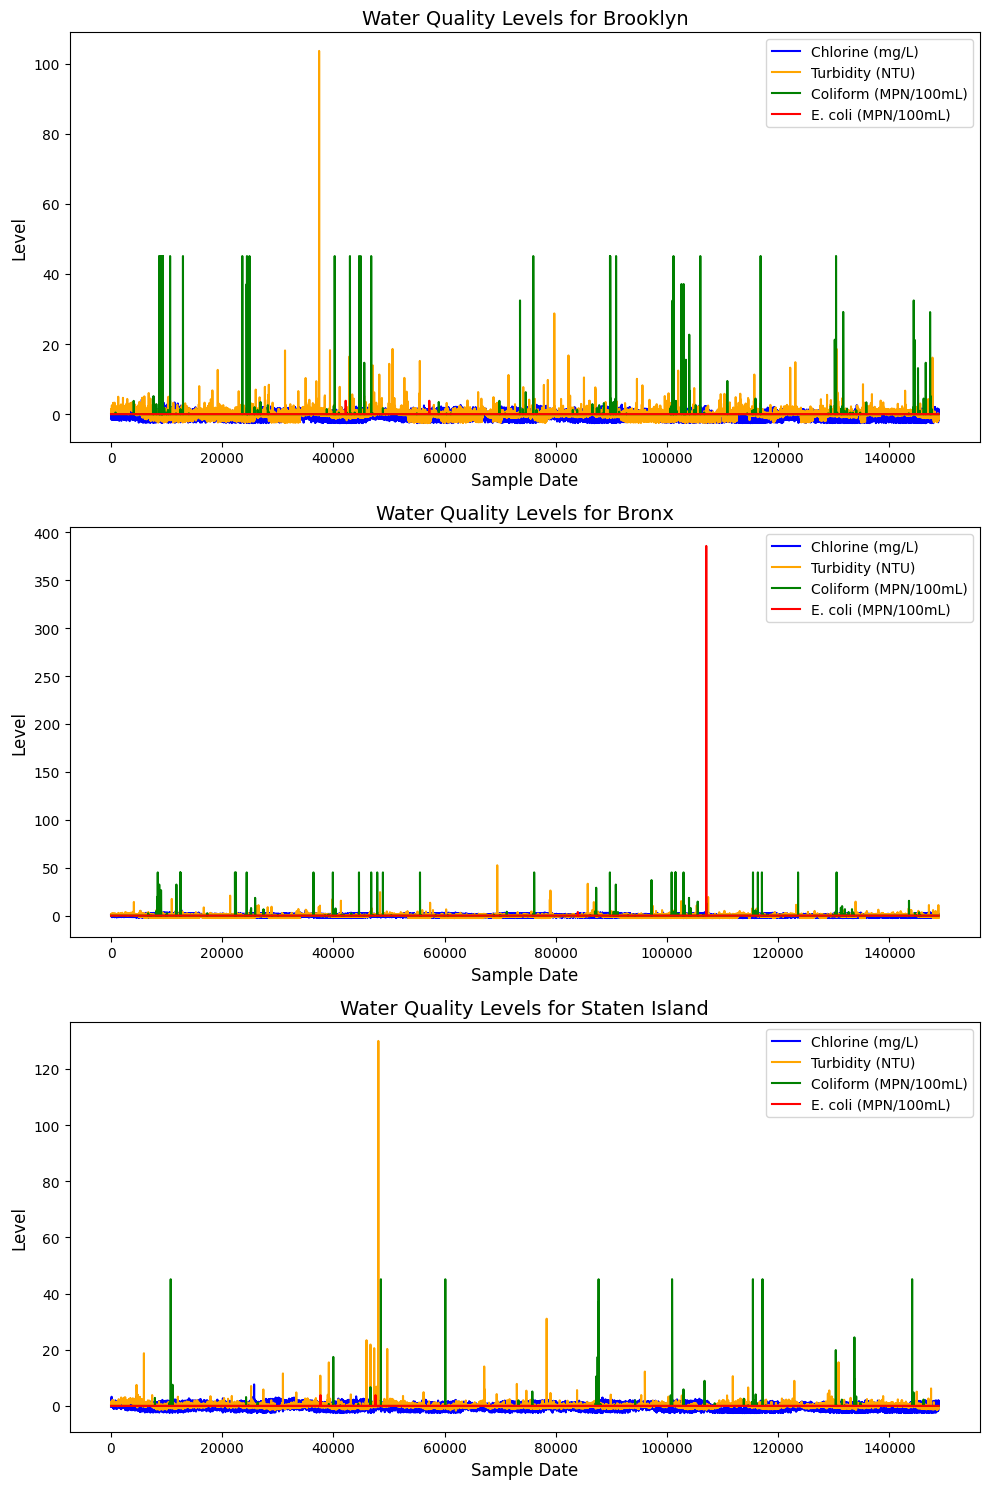

In [13]:
import seaborn as sns

# load your data
merged_df = pd.read_csv('../data/merged_data_with_borough.csv')

# define the list of boroughs to plot
boroughs_to_plot = ['Brooklyn', 'Bronx', 'Staten Island']

# set up a figure to hold multiple subplots (3 boroughs)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# loop over each borough and create a plot
for i, borough in enumerate(boroughs_to_plot):
    # filter data for the current borough
    borough_data = merged_df[merged_df['borough'] == borough]
    
    # plotting the data for this borough
    axes[i].plot(borough_data.index, borough_data['chlorine'], label='Chlorine (mg/L)', color='blue')
    axes[i].plot(borough_data.index, borough_data['turbidity'], label='Turbidity (NTU)', color = 'orange')
    axes[i].plot(borough_data.index, borough_data['coliform'], label='Coliform (MPN/100mL)', color = 'green')
    axes[i].plot(borough_data.index, borough_data['ecoli'], label='E. coli (MPN/100mL)', color='red')
    
    # set labels and title for each subplot
    axes[i].set_title(f'Water Quality Levels for {borough}', fontsize=14)
    axes[i].set_xlabel('Sample Date', fontsize=12)
    axes[i].set_ylabel('Level', fontsize=12)
    axes[i].legend(loc='upper right')

# adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()